# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Милютина Лилия Александровна

**Дедлайн**: 3 октября 2021

In [ ]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь датасетом, то во-первых, проверьте нет ли его среди датасетов `torchvison`. 

Мы будем работать с `FashionMNIST`. Скачаем его, но будем использовать это только как быстрый и удобный способ скачать данные. 

Структруру класса датасет реализуем сами.

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Воспользуемся функций загрузки данных из репозитория датасета.

In [ ]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [ ]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства в PyTorch предоставляется ряд утилит для загрузки датасетов, их предварительной обработки и взаимодействия с ними. Эти вспомогательные классы находятся в модуле `torch.utils.data`. Здесь следует обратить внимание на две основные концепции:

- `Dataset`, инкапсулирующий источник данных,
- `DataLoader`, отвечающий за загрузку датасета, возможно, в параллельном режиме.

Для создания новых датасетов наследуется класс `torch.utils.data.Dataset` и переопределяется метод `__len__`, так, чтобы он возвращал количество образцов в датасете, а также метод `__getitem__` для доступа к единичному значению по конкретному индексу. 

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары `(np.array, np.array)`, массивы имеют следующие размерности и типы: `(28, 28)`, тип элемента `np.float32`; и `(1,)`, тип элемента `int`.

In [ ]:
class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None, 
                 label_transform=None):
        if train:
            images, labels = load_mnist(f"{path}/raw")
        else:
            images, labels = load_mnist(f"{path}/raw", kind="t10k")
        
        self.img_labels = labels
        self.transform = image_transform
        self.target_transform = label_transform

        image_size = int(np.sqrt(images.shape[1]))
        self.images = images.reshape(-1, image_size, image_size)

    def __len__(self,):
        length = len(self.img_labels)
        return length

    def __getitem__(self, idx):
        label = np.asarray(self.img_labels[idx])
        img = self.images[idx, :, :]
        if self.transform:
          img = self.transform(img)
        if self.target_transform:
          label = self.target_transform(label)
        return img, label


In [ ]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы датасета.

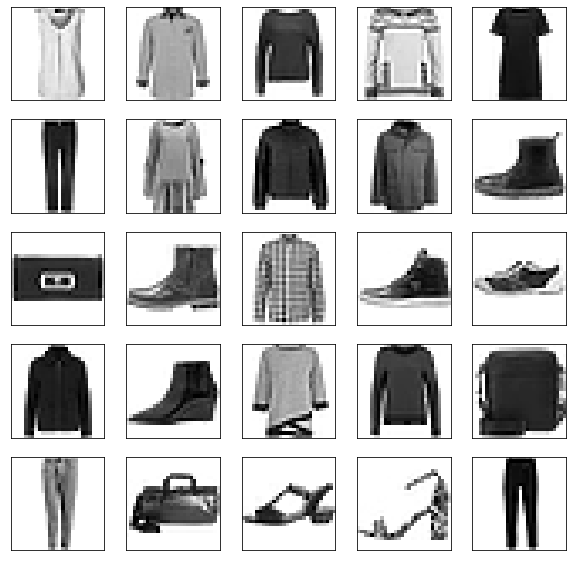

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  random_image_ind = np.random.randint(0, len(test_dataset))
  image, label = test_dataset[random_image_ind]
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
plt.show()

В конструктор датасета обычно можно передать преобразование `torchvision.transforms`. С помощью которых можно преобразовать исходные данные. 

Такое преобразование может привести, например, исходные данные к тензорам.

Реализуйте поддержку преобразований в вашем датасете. Проверьте, что приведение типов работает корректно. 

In [ ]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [ ]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST", 
                            train=False, 
                            image_transform=transform, 
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform, 
                             label_transform=transform
                             )

In [ ]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы датасета могут быть объединены в батчи явно и неявно. Если данные могут быть сконкатенированы или объединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать дефолтное объединение в батч, то можно написать собственную функцию. 

Реализуйте функцию, преобразующую последовательность элементов массива в батч. 

In [ ]:
def collate(batch):
    imgs = []
    labels = []
    for i, item in enumerate(batch):
        img, label = item
        imgs.append(img)
        labels.append(label)
    imgs = torch.nn.utils.rnn.pad_sequence(imgs, batch_first=True, padding_value=0)
    return imgs, torch.tensor(labels).type(torch.LongTensor)

Убедитесть, что все работает корректно. 

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязной сети. 

Для начала нам понадобится реализовать прямой и обратный проход через слои. 

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиенинт. 

In [ ]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(x):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return x

    @staticmethod
    def backward(grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Затем обернем функцию в `nn.Module()`, сделав её таким образом "кирпичеком" нашей 

---

нейронки. 

In [ ]:
class IdentityLayer(nn.Module):

    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply
    
    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Слой нелинейности ReLU
Для начала реализуем слой нелинейности $ReLU(x) = max(x, 0)$. Параметров у слоя нет. Метод forward должен вернуть результат поэлементного применения ReLU к входному массиву, метод backward - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [ ]:
class MyReLU(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input


In [ ]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    
    def forward(self, input):
        y = MyReLU.apply(input)
        return y

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [ ]:
relu = ReLU()
x = torch.rand([16, 10], requires_grad=True).double()
assert gradcheck(relu, x, eps=1e-4, atol=1e-3)

Сравнение с `PyTorch`. 

In [ ]:
our_relu = ReLU()
torch_relu = torch.nn.ReLU()
x = torch.rand([16, 10], requires_grad=True).double()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой
Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

In [ ]:
class Linear(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ctx.save_for_backward(inp, weight, bias)
        inp = inp.float()
        output = inp.matmul(weight.t()) + bias
        return output
    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        input = input.float()
        grad_input = grad_weight = grad_bias = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.matmul(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().matmul(input)
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
        return grad_input, grad_weight, grad_bias

In [ ]:
class Dense(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution
        # do not forget using nn.Parameter for bias and weight
        self.input_units = input_units
        self.output_units = output_units

        self.weight = nn.Parameter(torch.normal(0, 0.01, size = (output_units, input_units)))
        self.bias = nn.Parameter(torch.zeros(output_units))
        
    def forward(self,inp):
        return Linear.apply(inp, self.weight, self.bias)


Проверим градиент, а также сравним работу нашего модуля с имплементированным в `PyTorch`. 

Проверка градиента:

In [ ]:
linear = Dense(10, 10)
x = torch.rand([15, 10], requires_grad=True)
assert gradcheck(linear, x, eps=1e-3, atol=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/autograd/gradcheck.py:633: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  f'Input #{idx} requires gradient and '


Сравнение с `PyTorch`. 

In [ ]:
weight = torch.normal(0, 1, (10, 10))
bias = torch.zeros(10)
x = torch.rand([10, 10], requires_grad=True)

our_linear = Dense(10, 10)
torch_linear = torch.nn.Linear(10, 10)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

assert torch.norm(torch_linear(x.float()) - our_linear(x)) < 1e-5

### 2.3 LogSoftmax

Реализация softmax-слоя и функции потерь
Для решения задачи многоклассовой классификации обычно используют softmax в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой LogSoftmax (без параметров). Метод forward должен вычислять логарифм от softmax, а метод backward - пропускать градиенты. В общем случае в промежуточных вычислениях backward получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент grad_output - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [ ]:
class MyLogSoftmax(Function):
    @staticmethod
    def forward(ctx, inp):
        result = torch.nn.functional.log_softmax(inp)
        ctx.save_for_backward(inp)
        return result
    
    @staticmethod        
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        result = torch.eye(input.shape[0]) - torch.nn.functional.softmax(input)
        return grad_output.matmul(result)

In [ ]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return MyLogSoftmax.apply(input)

Проверка градиентов.

In [ ]:
log_softmax = LogSoftmax()
x = torch.rand([1, 1], requires_grad=True).double()
assert gradcheck(log_softmax, x, eps=1e-3, atol=1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


### 2.4 Dropout
Реализуйте слой Dropout.

In [ ]:
class MyDropout(Function):
    @staticmethod
    def forward(ctx, inp, p):
        ctx.save_for_backward(inp)
        binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
        return inp * binomial.sample(inp.size()) * (1.0/(1-self.p))
        
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        result = input
        return grad_output.matmul(result)

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        
    def forward(self, input):
      return MyDropout.apply(input, p)

### 2.5 CrossEntropy

Реализуйте функцию потерь - кроссэнтропию. В разделе 2.3 приведены полезные формулы.

In [ ]:
class CrossEntropy(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ctx.save_for_backward(activations, target)
        log_prob = - MyLogSoftmax.apply(activations)
        loss = torch.gather(log_prob, 1, target.unsqueeze(1)).view(-1)
        loss = loss.mean()
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        activations, target,  = ctx.saved_tensors
        p = torch.nn.functional.softmax(activations)

        t = torch.zeros(p.size(), device=activations.device)
        for n in range(t.size(0)):
            t[n][target.data[n]] = 1
        
        grad_activations = (p - t) / t.shape[0]
        grad_activations = grad_output * grad_activations
        return grad_activations, None

class CrossEntropyLoss(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, activations, target):
        return CrossEntropy.apply(activations, target)

Проверка градиентов.

In [ ]:
ce = CrossEntropyLoss()
x = torch.rand([16, 10], requires_grad=True).double()
target = torch.arange(16) % 10
assert gradcheck(ce, inputs=(x, target), eps=1e-4, atol=1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязных слоев.

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.input_size = input_size
        
        layers = []
        layers.append(torch.nn.Flatten())
        for i in range(num_layers + 1):
            if i == 0:
                layers.append(Dense(self.input_size, hidden_layers_size))
                layers.append(ReLU())
            else:
                if i == num_layers:
                    layers.append(Dense(hidden_layers_size, num_classes))
                    layers.append(torch.nn.Softmax(dim=1))
                else:
                    layers.append(Dense(hidden_layers_size, hidden_layers_size))
                    layers.append(ReLU())
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, inp):
        model = nn.Sequential(*self.layers)
        y = model(inp)
        return y
        
    def predict(self, inp):
        y = self.forward(inp)
        y = torch.argmax(y, dim=1)
        return y

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать. 

In [ ]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [ ]:
# accuract metric for our classififcation
def accuracy(model_answers, labels):
  return torch.mean((model_answers == labels).float())

In [ ]:
def perform_epoch(model, loader, criterion, 
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_answers in loader:
            batch_data = batch_data.to(device)
            batch_answers = batch_answers.to(device)          
            model_answers = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_answers, batch_answers)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step() 

            one_batch_loss = float(criterion(model_answers, batch_answers))
            one_batch_acc = accuracy(model_prediction, batch_answers)
            
            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1 
    return (total_loss / total_n, total_acc / total_n) 

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с дефолтными пораметрами.

In [ ]:
model = Network()
optimizer = Adam(model.parameters())
criterion = CrossEntropyLoss()

In [ ]:
print(model)

Network(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dense()
    (2): ReLU()
    (3): Dense()
    (4): ReLU()
    (5): Dense()
    (6): ReLU()
    (7): Dense()
    (8): ReLU()
    (9): Dense()
    (10): ReLU()
    (11): Dense()
    (12): Softmax(dim=1)
  )
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion, 
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : train loss {loss}, train accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch - 0 : train loss 2.2187248935699464, train accuracy 0.2357858419418335
Current learning rate: 0.001
Epoch - 1 : train loss 2.0977883914113047, train accuracy 0.36315426230430603
Current learning rate: 0.001
Epoch - 2 : train loss 2.09760873028636, train accuracy 0.36348867416381836
Current learning rate: 0.001
Epoch - 3 : train loss 2.114161060422659, train accuracy 0.3466717004776001
Current learning rate: 0.001
Epoch - 4 : train loss 2.143148218214512, train accuracy 0.31793808937072754
Current learning rate: 0.001
Epoch - 5 : train loss 2.095349650233984, train accuracy 0.3656213581562042
Current learning rate: 0.001
Epoch - 6 : train loss 2.091664196640253, train accuracy 0.36947235465049744
Current learning rate: 0.001
Epoch - 7 : train loss 2.2329826738238334, train accuracy 0.22815336287021637
Current learning rate: 0.001
Epoch - 8 : train loss 2.2589062004089357, train accuracy 0.2022363841533661
Current learning rate: 0.001
Epoch - 9 : train loss 2.2810517975687983, trai

In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 2.2810517975687983, accuracy 0.1801033914089203
Current learning rate: 0.001


Дальше:
- Проведите эксперементы с числом слоев. 
- Постройте графики зависимости качества на трейне и нa тесте от числа слоев. Для получения статистически значимых результатов повторите эксперемени несколько раз.
- Сделайте выводы.

In [42]:
layers = np.arange(1, 7)
losses_train = []
losses_test = []
accs_train = []
accs_test = []
for num_layers in layers:
    loss_train = []
    acc_train = []
    loss_test = []
    acc_test = []
    for repeat in range(5):
        model = Network(num_layers=num_layers)
        optimizer = Adam(model.parameters())
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        for epoch in range(10):
            loss_train_val, acc_train_val = perform_epoch(model, train_dataloader, criterion, 
                                        optimizer=optimizer, device=device)
            
            loss_test_val, acc_test_val = perform_epoch(model, test_dataloader, criterion, device=device)
            
            print(f"Repeat - {repeat}, Number of layers - {num_layers}, Epoch - {epoch}")
            print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
            print(f"Train: loss {loss_train_val}, accuracy {acc_train_val}")
            print(f"Test: loss {loss_test_val}, accuracy {acc_test_val}")

        print('----------------------')
        loss_train.append(loss_train_val)
        acc_train.append(acc_train_val.item())
        loss_test.append(loss_test_val)
        acc_test.append(acc_test_val.item())
    losses_train.append(np.mean(loss_train))
    accs_train.append(np.mean(acc_train))
    losses_test.append(np.mean(loss_test))
    accs_test.append(np.mean(acc_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Repeat - 0, Number of layers - 1, Epoch - 0
Current learning rate: 0.001
Train: loss 1.9345741205215454, accuracy 0.5260336399078369
Test: loss 1.988910278280278, accuracy 0.4719637334346771
Repeat - 0, Number of layers - 1, Epoch - 1
Current learning rate: 0.001
Train: loss 1.8650023164451122, accuracy 0.5959835648536682
Test: loss 1.8694840371161923, accuracy 0.5912047028541565
Repeat - 0, Number of layers - 1, Epoch - 2
Current learning rate: 0.001
Train: loss 1.8717257034480572, accuracy 0.589333176612854
Test: loss 1.8459708694217802, accuracy 0.6151425242424011
Repeat - 0, Number of layers - 1, Epoch - 3
Current learning rate: 0.001
Train: loss 1.8518329998552798, accuracy 0.6092695593833923
Test: loss 1.8572538999960697, accuracy 0.6037982702255249
Repeat - 0, Number of layers - 1, Epoch - 4
Current learning rate: 0.001
Train: loss 1.8520728167593479, accuracy 0.6090346574783325
Test: loss 1.8436087083959507, accuracy 0.6174911260604858
Repeat - 0, Number of layers - 1, Epoch - 

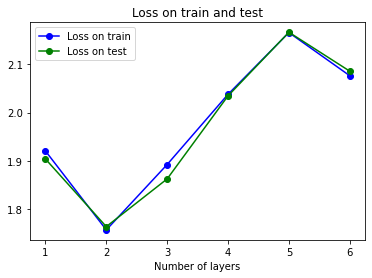

In [43]:
plt.plot(layers, losses_train, 'ro-', label='Loss on train', color='blue')
plt.plot(layers, losses_test, 'ro-', label='Loss on test', color='green')
plt.xlabel("Number of layers")
plt.title("Loss on train and test")
plt.legend(loc="best")
plt.show()

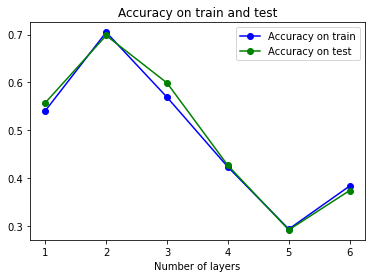

In [44]:
plt.plot(layers, accs_train, 'ro-', label='Accuracy on train', color='blue')
plt.plot(layers, accs_test, 'ro-', label='Accuracy on test', color='green')
plt.xlabel("Number of layers")
plt.title("Accuracy on train and test")
plt.legend(loc="best")
plt.show()

**Выводы**

1. Ошибка на тесте и трейне практически одинаковы, что говорит о том, что модель слишком простая.

2. Лучшее качество было получено при 2-х слоях.

3. При числе слоев больше 2-х, модель обучается хуже. Ведь размерность скрытых слоев одинакова и, кажется, что начинаются проблемы с градиентами при обратном распространении, и функция хуже минимизируется. 
Но здесь стоит сделать ремарку о том, что начальная инициализация весов очень сильно влияет на конечный результат. Возможно, поигравшись с ней, можно было достигнуть и лучших результатов.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от классики до супермодных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam. 

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание. 

Ниже приведен пример реализации SGD в рамках фреймворка **PyTorch.**

In [ ]:
class MySotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(MySotaOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация модной активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, Hardswish. Сравните сеть с вашей активацией и с ReLU. 

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание. 